In [145]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, facet_grid, labs, geom_point, theme_dark, geom_line, theme, geom_histogram, geom_density
import pandas as pd
import arviz as az
from tqdm import tqdm

# Posterior via grid approximation

In [87]:
def posterior_grid_approx(points=5, success=6, tosses=9, prior=lambda x:1):
    """
    success ~ Binomial(n,p)
    p ~ Uniform(0,1)
    """
    grid = np.linspace(0, 1, points)
    likelihood = stats.binom.pmf(success, tosses, grid)
    unnormalized_posterior = likelihood*prior(grid) 
    normalized_posterior =  unnormalized_posterior / sum(unnormalized_posterior) 
    return pd.DataFrame({'param_value':grid, 'p':normalized_posterior})

def plot_posterior(posterior):
    return (ggplot(posterior, aes(x='param_value', y='p'))
            + geom_line()
            + geom_point())

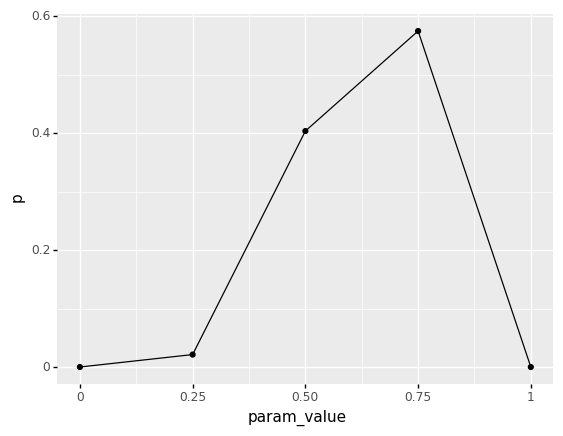

<ggplot: (314642469)>

In [88]:
plot_posterior(posterior_grid_approx(5))

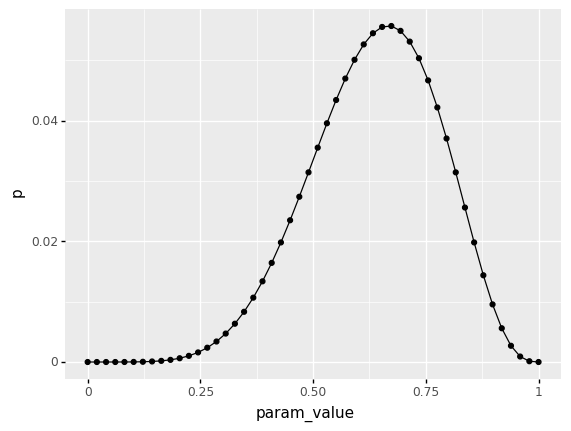

<ggplot: (314567473)>

In [89]:
plot_posterior(posterior_grid_approx(50))

# Quadratic Approximation

- Under general assumptions, near the mode the posterior is approximately Gaussian. Log-posterior is then a quadratic function we can fit via an optimization procedure.
- Uniform prior + Binomial likelihood leads to a Beta Posterior, which kind of matches the beta's parameters interpretation as 'fake trials'.

# Metropolis

In [90]:
def posterior_metropolis_approx(n_samples=5, success=6, tosses=9):
    """
    Using a half normal distribution as 
    proposal
    """
    rejections = 0
    old_sample = np.array([0.5])
    samples = np.zeros(n_samples)
    for i,_ in enumerate(range(n_samples)):  
        new_sample = stats.norm.rvs(old_sample, 0.1, size=1, random_state=None)
        if new_sample < 0:
            # this turns normal into half normal.
            new_sample = abs(new_sample)
        if new_sample > 1:
            new_sample = 2-new_sample
        p_new_sample = stats.binom.pmf(success, n=tosses, p=new_sample)
        p_old_sample = stats.binom.pmf(success, n=tosses, p=old_sample)
        # accept with prob p(p_new)/p(p_old)
        if stats.uniform(0,1).rvs() < (p_new_sample/p_old_sample):
            samples[i] = new_sample
            old_sample = new_sample
        else:
            samples[i] = old_sample
            rejections+=1
    print(rejections)
    return samples

216


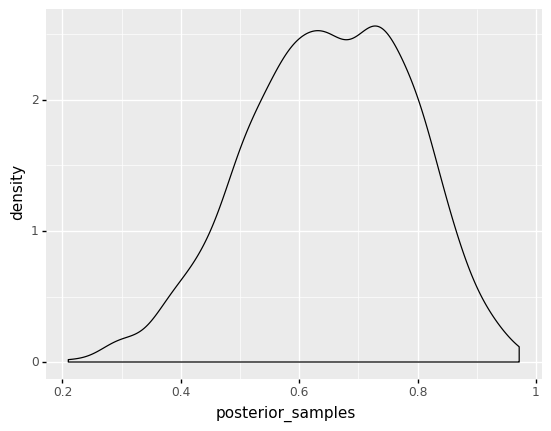

<ggplot: (316453105)>

In [91]:
(ggplot(pd.DataFrame({'posterior_samples':posterior_metropolis_approx(1000)}), aes(x='posterior_samples'))
+ geom_density()
)

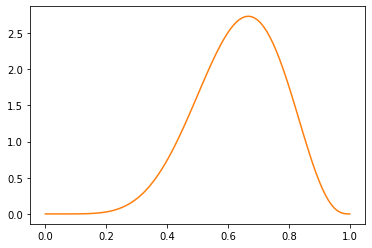

In [92]:
x=np.linspace(0,1,100)
success = 6
fail = 3
plt.plot(x, stats.beta.pdf(x, success+ 1, fail + 1), "C1", label="True posterior")

- Different scales for the proposal may lead to different shapes of the posterior (exploration/exploitation).

# End of chapter problems

## 2M1

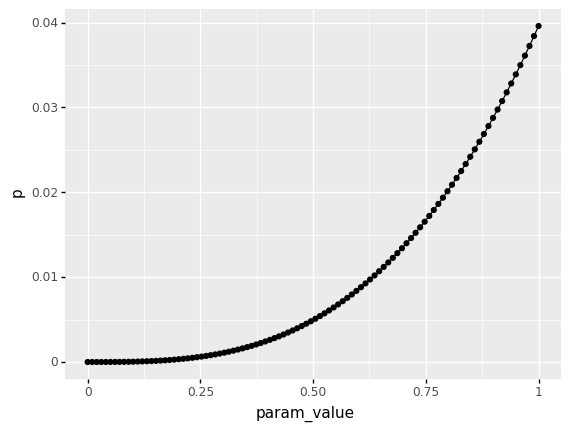

<ggplot: (316478088)>

In [93]:
plot_posterior(posterior_grid_approx(100, 3, 3))

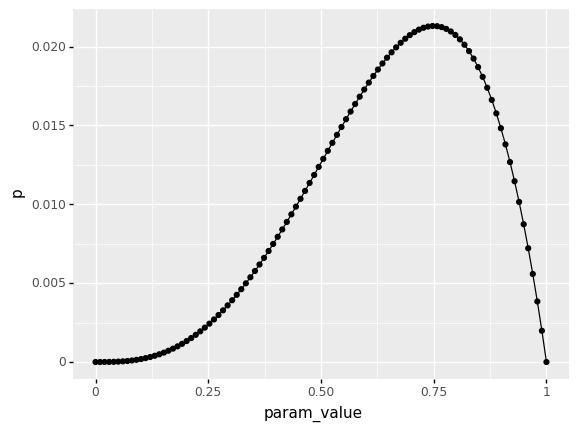

<ggplot: (314704589)>

In [94]:
plot_posterior(posterior_grid_approx(100, 3, 4))

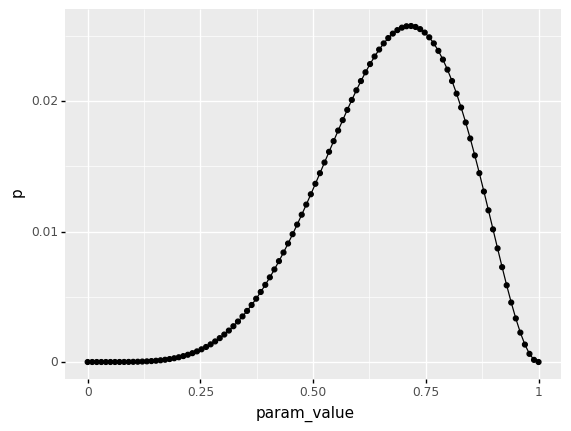

<ggplot: (314235124)>

In [95]:
plot_posterior(posterior_grid_approx(100, 5, 7))

## 2M2

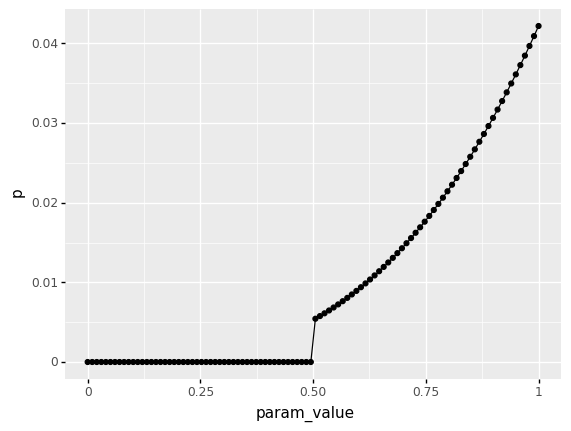

<ggplot: (314603894)>

In [96]:
plot_posterior(posterior_grid_approx(100, 3, 3, lambda x: np.array([0 if xi<0.5 else 1 for xi in x])))

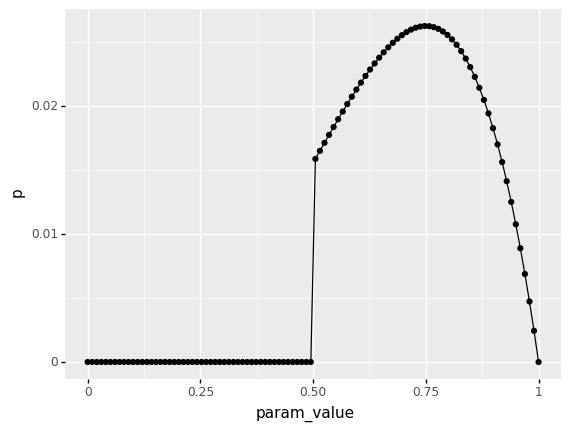

<ggplot: (316393960)>

In [97]:
plot_posterior(posterior_grid_approx(100, 3, 4, lambda x: np.array([0 if xi<0.5 else 1 for xi in x])))

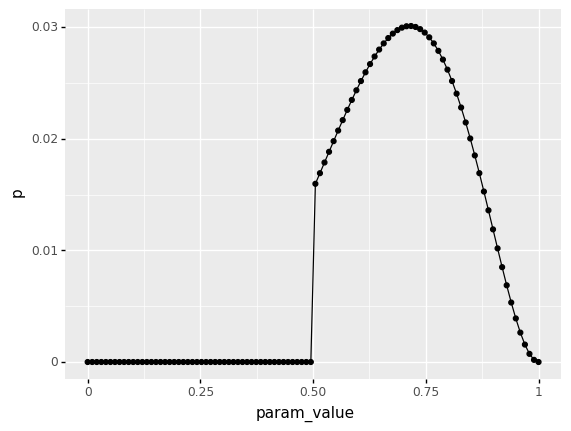

<ggplot: (316506408)>

In [98]:
plot_posterior(posterior_grid_approx(100, 5, 7, lambda x: np.array([0 if xi<0.5 else 1 for xi in x])))

## 3M1



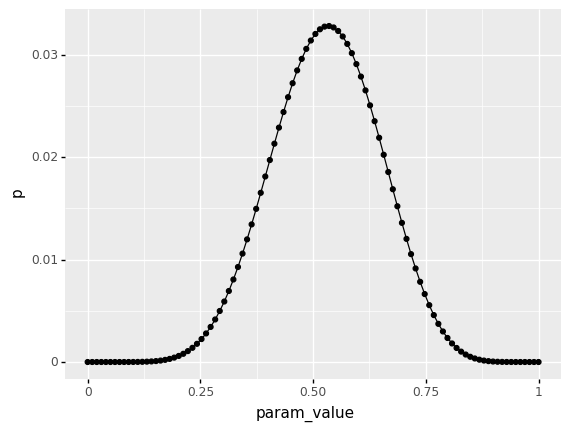

<ggplot: (316742349)>

In [114]:
posterior = posterior_grid_approx(100, 8, 15)
plot_posterior(posterior)

In [115]:
samples = np.random.choice(posterior.param_value, p=posterior.p, size=100000)

In [116]:
az.hdi(samples, 0.9)

array([0.34343434, 0.72727273])

Posterior predictive

(array([  379.,  1133.,  8041.,  8342., 25114., 14688., 25454.,  8366.,
         7466.,  1017.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

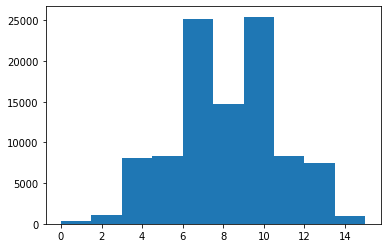

In [117]:
ppd = np.random.binomial(n=15, p=samples)
plt.hist(ppd)

(array([78.,  3.,  3.,  2.,  2.,  1.,  2.,  2.,  2.,  5.]),
 array([0.00000000e+00, 9.48236691e-09, 1.89647338e-08, 2.84471007e-08,
        3.79294677e-08, 4.74118346e-08, 5.68942015e-08, 6.63765684e-08,
        7.58589353e-08, 8.53413022e-08, 9.48236691e-08]),
 <BarContainer object of 10 artists>)

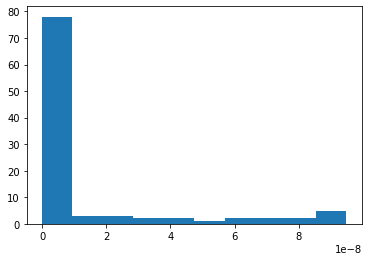

In [118]:
plt.hist(stats.binom.pmf(6, n=9, p=posterior.p))

Our data is 8 successes, so at least the expectation matches. It is also true that P(6)>P(8)

In [119]:
stats.binom.pmf(np.linspace(0, 15, 16), n=15, p=0.7),

(array([1.43489070e-08, 5.02211745e-07, 8.20279184e-06, 8.29393397e-05,
        5.80575378e-04, 2.98028694e-03, 1.15900048e-02, 3.47700143e-02,
        8.11300333e-02, 1.47235986e-01, 2.06130381e-01, 2.18623131e-01,
        1.70040213e-01, 9.15601148e-02, 3.05200383e-02, 4.74756151e-03]),)

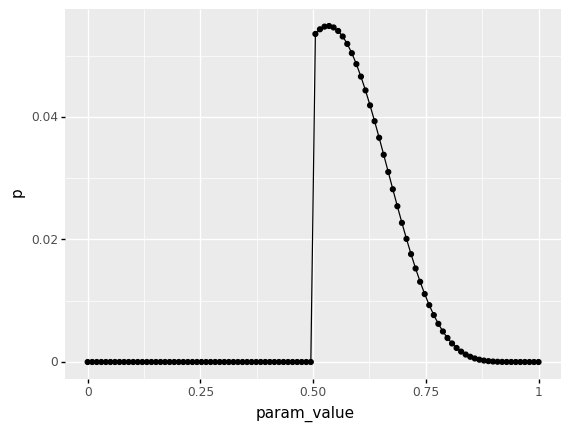

<ggplot: (316837765)>

In [120]:
posterior = posterior_grid_approx(100, 8, 15, lambda x: np.array([0 if xi<0.5 else 1 for xi in x]))
plot_posterior(posterior)

In [121]:
samples = np.random.choice(posterior.param_value, p=posterior.p, size=100000)

In [122]:
az.hdi(samples, 0.9) # HDPI is tighter

array([0.50505051, 0.71717172])

(array([8.0000e+00, 7.3000e+01, 1.5500e+03, 3.3290e+03, 1.8457e+04,
        1.5784e+04, 3.4186e+04, 1.2968e+04, 1.1993e+04, 1.6520e+03]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

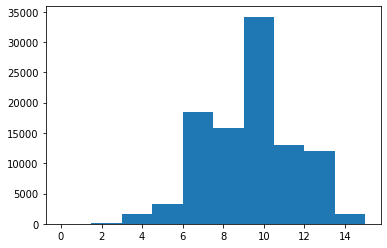

In [123]:
ppd = np.random.binomial(n=15, p=samples)
plt.hist(ppd)

In [124]:
stats.binom.pmf(6, n=9, p=0.7),

(0.2668279320000001,)

(array([86.,  1.,  2.,  1.,  1.,  0.,  1.,  1.,  2.,  5.]),
 array([0.00000000e+00, 1.93079072e-07, 3.86158144e-07, 5.79237216e-07,
        7.72316288e-07, 9.65395360e-07, 1.15847443e-06, 1.35155350e-06,
        1.54463258e-06, 1.73771165e-06, 1.93079072e-06]),
 <BarContainer object of 10 artists>)

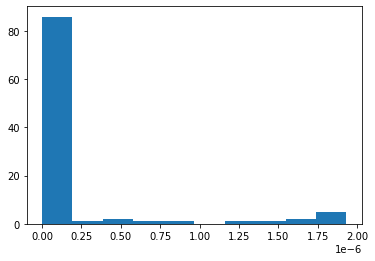

In [125]:
plt.hist(stats.binom.pmf(6, n=9, p=posterior.p))

In [146]:
grid = np.linspace(0, 1, 10)

trials_for_p = []

for p in grid:
    number_of_trials = []
    for repeat in tqdm(range(0,100)):
        successes = 0
        tosses = 0
        interval = (0,1)
        while interval[1] - interval[0] > 0.05:
            successes += np.random.binomial(1, p)
            tosses += 1  
            interval = stats.beta.interval(0.99, successes + 1, tosses - successes + 1)  
        number_of_trials.append(tosses)
    mean = np.array(number_of_trials).mean()
    trials_for_p.append(mean) 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.84it/s]


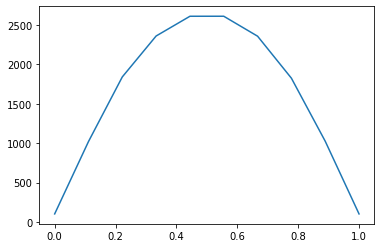

In [137]:
plt.plot(grid, trials_for_p)

# Hard section

In [147]:
birth1 = np.array([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
                   1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1])
birth2 = np.array([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
                   1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
                   0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

In [151]:
boys = sum(birth1)+sum(birth2)

In [152]:
boys

111

In [155]:
births = len(birth1)+len(birth2)

In [156]:
births

200

# 3H1

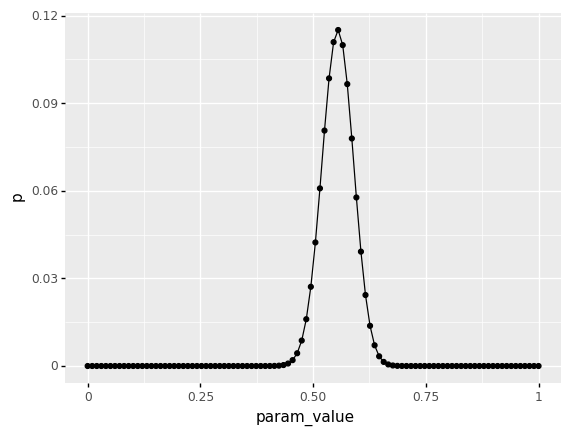

<ggplot: (314312605)>

In [157]:
posterior = posterior_grid_approx(100, boys, births)
plot_posterior(posterior)

In [163]:
samples = np.random.choice(posterior.param_value, p=posterior.p, size=int(1e5))

In [167]:
[az.hdi(samples, density) for density in [0.5, 0.89, 0.97]]

[array([0.54545455, 0.58585859]),
 array([0.50505051, 0.60606061]),
 array([0.48484848, 0.62626263])]

# 3H3

In [172]:
replicates = stats.binom(p=samples, n=200).rvs()

(array([4.3000e+01, 6.9400e+02, 4.2210e+03, 1.7483e+04, 2.9594e+04,
        3.1243e+04, 1.3831e+04, 2.5860e+03, 2.9400e+02, 1.1000e+01]),
 array([ 69. ,  77.6,  86.2,  94.8, 103.4, 112. , 120.6, 129.2, 137.8,
        146.4, 155. ]),
 <BarContainer object of 10 artists>)

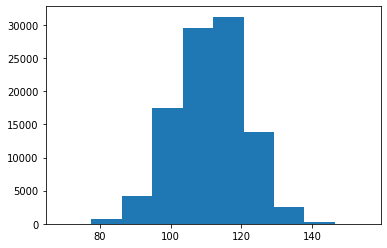

In [174]:
plt.hist(replicates)

Consistent with observations

# 3H4

In [ ]:
I do not interpret the problem as the Pymc solution, may need to further check.

In [177]:
sum(birth1)

51

In [185]:
len(birth1)

100

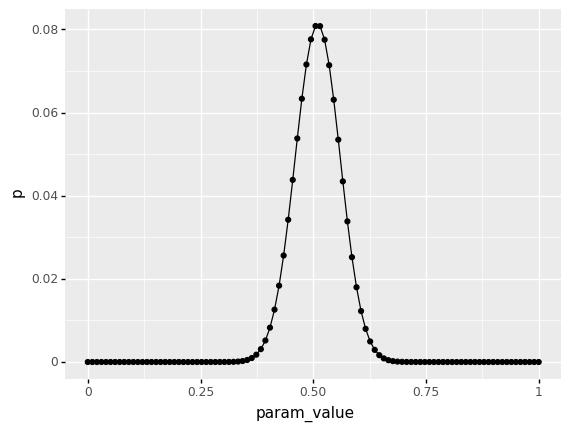

<ggplot: (314533756)>

In [180]:
posterior = posterior_grid_approx(100, sum(birth1), len(birth1))
plot_posterior(posterior)

In [181]:
samples = np.random.choice(posterior.param_value, p=posterior.p, size=int(1e5))

In [182]:
[az.hdi(samples, density) for density in [0.5, 0.89, 0.97]]

[array([0.47474747, 0.53535354]),
 array([0.43434343, 0.58585859]),
 array([0.39393939, 0.60606061])]

In [183]:
replicates = stats.binom(p=samples, n=200).rvs()

(array([3.0000e+00, 1.5100e+02, 1.9600e+03, 9.6340e+03, 2.6941e+04,
        3.4561e+04, 1.9392e+04, 6.4720e+03, 8.4000e+02, 4.6000e+01]),
 array([ 45. ,  55.7,  66.4,  77.1,  87.8,  98.5, 109.2, 119.9, 130.6,
        141.3, 152. ]),
 <BarContainer object of 10 artists>)

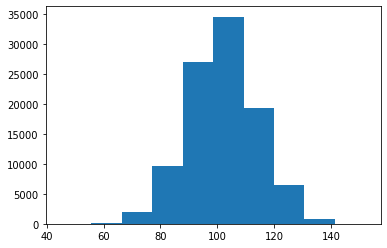

In [184]:
plt.hist(replicates)

# 3H5

Girl + Boy

In [188]:
first_females = sum(abs(birth1-1))

In [189]:
first_females

49

In [194]:
boys_followed_girls = sum(abs(birth1-1)*birth2)

In [195]:
boys_followed_girls

39

Given my model's posterior distribution, I simulate 49 births, and the chance of getting 39 boys is too low. After having a girl, it seems that there's greater chance of a boy, but the model doesn't account for that.

In [199]:
posterior_predictive_samples = np.random.binomial(n=49, p=samples)

(array([8.0000e+00, 2.7000e+02, 3.6190e+03, 1.6953e+04, 3.3950e+04,
        3.0877e+04, 1.2168e+04, 2.0300e+03, 1.2200e+02, 3.0000e+00]),
 array([ 6. ,  9.9, 13.8, 17.7, 21.6, 25.5, 29.4, 33.3, 37.2, 41.1, 45. ]),
 <BarContainer object of 10 artists>)

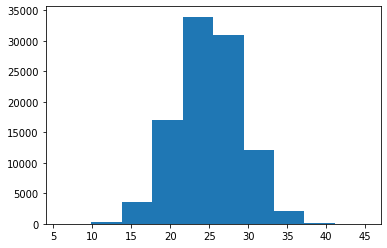

In [201]:
plt.hist(posterior_predictive_samples)